## Lectura de datos

### Librerias necesarias

In [ ]:
!pip install torch==1.12.1 -q
!pip install numpy matplotlib pandas bokeh openpyxl PyPDF2 requests beautifulsoup4 openpyxl evidently -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
snowflake-connector-python 2.8.0 requires cryptography<37.0.0,>=3.1.0, but you have cryptography 38.0.4 which is incompatible.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.4.2 requires typer<0.5.0,>=0.3.0, but you have typer 0.9.0 which is incompatible.
snowflake-connector-python 2.8.0 requires charset-normalizer<3,>=2, but you have charset-normalizer 3.3.2 which is incompatible.
snowflake-connector-python 2.8.0 requires cryptography<37.0.0,>=3.1.0, but you have cryptography 38.0.4 which is incompatible.
snowflake-connector-python 2.8.0 requires urllib3<1.27,>=1.21.1, but you have

In [ ]:
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as t_data

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Lectura

In [ ]:
data = pd.read_excel("/work/dairy_products_18-23_clean.xlsx")
data = data[['Week', ' WHEY CENTRAL', 'Lactose']]
data.head()

,Week,WHEY CENTRAL,Lactose
0,1/2/23 - 1/6/23,0.4100,0.4775
1,1/9/23 - 1/13/23,0.4025,0.4725
2,1/16/23 - 1/20/23,0.3725,0.4675
3,1/23/23 - 1/27/23,0.3600,0.4450
4,1/30/23 - 2/3/23,0.3600,0.4400


In [ ]:
filas_con_faltantes = data[data.isnull().any(axis=1)]
indices_faltantes = filas_con_faltantes.index
indices_faltantes

Int64Index([192], dtype='int64')

In [ ]:
data[:][191:194]

,Week,WHEY CENTRAL,Lactose
191,12/14/20 - 12/18/20,0.435,0.43
192,12/21/20 - 12/25/20,NaN,NaN
193,12/28/20 - 1/1/2021,0.435,0.42


In [ ]:
data[' WHEY CENTRAL'][192:193] = data[' WHEY CENTRAL'][191:194].mean()
data['Lactose'][192:193] = data['Lactose'][191:194].mean()
data[:][191:194]

,Week,WHEY CENTRAL,Lactose
191,12/14/20 - 12/18/20,0.435,0.430
192,12/21/20 - 12/25/20,0.435,0.425
193,12/28/20 - 1/1/2021,0.435,0.420


In [ ]:
data['Week'] = pd.to_datetime(data['Week'].apply(lambda x: x.replace('-', ' ').split()[-1]))
data['Week'] = data['Week'].dt.strftime('%Y-%m-%d')
data = data.sort_values(by='Week', ascending=True).reset_index(drop=True)
# data = data.set_index('Week')
data.to_csv('data_pricing.csv')
data

,Week,WHEY CENTRAL,Lactose
0,2017-12-31,0.27000,0.2200
1,2018-01-07,0.26500,0.2200
2,2018-01-14,0.25750,0.2200
3,2018-01-21,0.24875,0.2125
4,2018-01-28,0.24250,0.2125
...,...,...,...
296,2023-08-11,0.25000,0.2000
297,2023-08-18,0.25250,0.2100
298,2023-08-25,0.25250,0.2100
299,2023-09-01,0.27000,0.2250


### Web Scraping: otra alternativa

Librerías para hacer el Web Scraping

In [ ]:
# Libreria para leer PDF
import PyPDF2

# Libreria para descargar archivos
import urllib.request

# Libreria para regular expresiones
import re

# Numpy
import numpy as np

# Pandas
import pandas as pd

# Librerias para graficar
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# Librerias para hacer web scrapping
import requests
from bs4 import BeautifulSoup
import json

# Libreria para manejo de archivos y directorios
import os

Leer los datos

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
# Web scrapping
url = 'https://usda.library.cornell.edu/concern/publications/zs25x847n?locale=en'

# Nos conectamos a la pagina
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

# Buscamos los botones que contengan el texto 'PDF'
pdf_buttons = soup.find_all('a', string=re.compile('PDF'))

# Obtenemos los links de los PDF
pdf_links = [pdf_button['href'] for pdf_button in pdf_buttons]

# Buscamos en toda la pagina <td class="attribute date_uploaded">Oct  4, 2023</td>
dates = soup.find_all('td', class_='attribute date_uploaded')
dates = [date.text.strip() for date in dates]

# Formateamos las fechas
dates = [pd.to_datetime(date).strftime('%Y-%m-%d') for date in dates]

# Descargamos los PDF
for pdf_link, date in zip(pdf_links, dates):
    file_name = 'data/' + date + '.pdf'
    print('Downloading', file_name)
    urllib.request.urlretrieve(pdf_link, file_name)

In [ ]:
# Leemos los archivos PDF en la carpeta data
pdf_files = os.listdir('data/')
pdf_files = ['data/' + file for file in pdf_files]
pdf_files = [PyPDF2.PdfReader(file) for file in pdf_files if file.endswith('.pdf')]

In [ ]:
def extract_pdf_text(pdf_files):
    # Get number of pages for each file
    pdf_files_pages = np.array([file.pages for file in pdf_files])

    # Extract text from each page of each file
    pdf_files_text = np.array([[page.extract_text() for page in file.pages] for file in pdf_files])

    # Keep only the first two pages of each file
    pdf_files_text = pdf_files_text[:, 0:2]

    return pdf_files_text

pdf_files_text = extract_pdf_text(pdf_files)
pdf_files_text.shape

(10, 2)

In [ ]:
def extract_table(page):
    # En la primer pagina la tabla comienza con el texto 9/20/2019
    # Usamos regular expresions para encontrar el indice donde comienza la tabla
    index = re.findall(r'\d+/\d+/\d+', page)
    index = page.index(index[-1]) + len(index[-1])
    page = page[index:].split('\n')

    # Eliminamos los espacios en blanco
    page = [x for x in page if x != '' and x != ' ']

    # La primer linea es el titulo de la tabla
    title = page[0]

    # La segunda linea son los encabezados pero antes cambiamos 'United States' por 'United-States'
    header = page[1].strip().replace('United States', 'United-States').split(' ')

    # La tercera linea nos dice las unidades de medida
    units = page[2].strip()

    # La cuarta linea nos das datos, entonces separamos las palabras de los numeros
    weighted_price = page[3].strip().replace('Weighted Price', 'Weighted-Price').split(' ')

    # La quinta nos da unidades de medida
    units_2 = page[4].strip()

    # La sexta linea nos da los datos, entonces separamos las palabras de los numeros
    sales = page[5].strip().split(' ')

    # Comenzamos a crear el dataframe
    df = pd.DataFrame(columns=['date', weighted_price[0], sales[0]])

    # Rellenamos el dataframe
    df['date'] = header[1:]
    df[weighted_price[0]] = weighted_price[1:]
    df[sales[0]] = sales[1:]

    # Formateamos la fecha primero hacemos minusculas y quitamos el guion y agreamos el año
    df['date'] = df['date'].str.upper().str.replace('-', '/') + '/2023'

    # Cambiamos el formato de la fecha
    df['date'] = pd.to_datetime(df['date'], format='%d/%b/%Y').dt.strftime('%Y-%m-%d')

    return df


# Creamos un dataframe vacio
df = pd.DataFrame()

# Iteramos sobre cada pagina
for page in pdf_files_text:
    # Extraemos la tabla
    df_page = extract_table(page[0])
    # print(df_page)

    # Concatenamos el dataframe
    df = pd.concat([df, df_page], axis=0)

# Eliminamos los elementos duplicados por fecha y mantenemos el último dato añadido
df = df.drop_duplicates(subset=['date'], keep='last')

# Reseteamos el indice
df = df.reset_index(drop=True)

# Removemos caracteres especiales de las columnas
df['Weighted-Price'] = df['Weighted-Price'].str.replace('*', '').str.replace(',', '')
df['Sales'] = df['Sales'].str.replace('*', '').str.replace(',', '')

# Convertimos las columnas a numericas
df['Weighted-Price'] = pd.to_numeric(df['Weighted-Price'])
df['Sales'] = pd.to_numeric(df['Sales'])
df

/tmp/ipykernel_97/622428142.py:66: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Weighted-Price'] = df['Weighted-Price'].str.replace('*', '').str.replace(',', '')
/tmp/ipykernel_97/622428142.py:67: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Sales'] = df['Sales'].str.replace('*', '').str.replace(',', '')


,date,Weighted-Price,Sales
0,2023-08-26,2.6941,5460136
1,2023-09-02,2.6765,3687024
2,2023-09-09,2.6704,5065739
3,2023-09-16,2.7069,4922432
4,2023-09-23,2.7736,4475051
5,2023-09-30,2.9360,4609889
6,2023-10-07,3.0906,3361816
7,2023-10-14,3.2740,3101681
8,2023-10-21,3.3212,2888628
9,2023-10-28,3.2878,3053552


## Visualizaciones

### Graficas de línea

Con estas visualizaciones podemos ver como van variando los precios a lo largo del tiempo

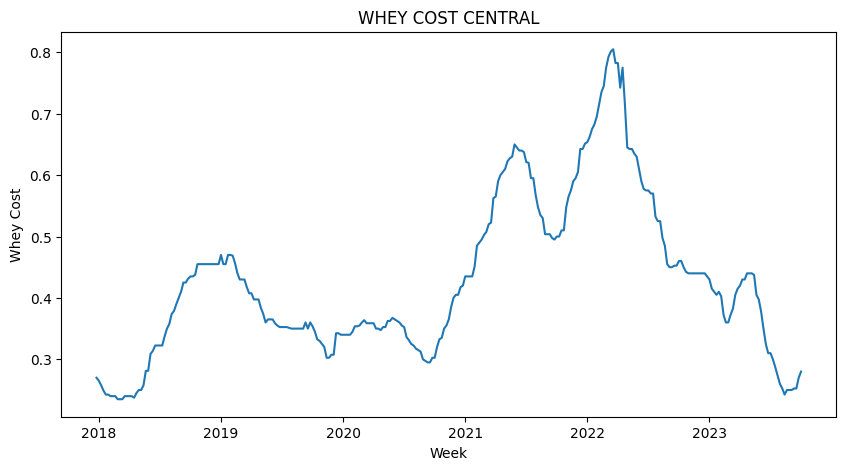

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data[" WHEY CENTRAL"])
plt.xlabel("Week")
plt.ylabel("Whey Cost")
plt.xticks([1 + i*52 for i in range(6)], [2018 + i for i in range(6)])
plt.title("WHEY COST CENTRAL")
plt.show()

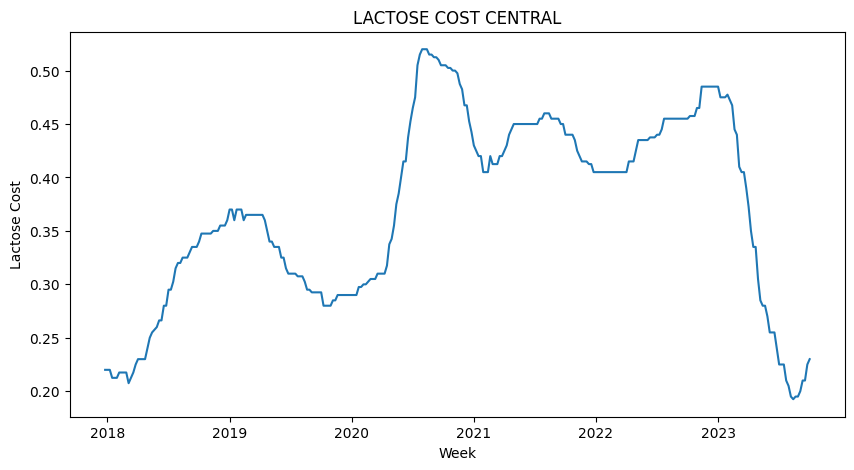

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data["Lactose"])
plt.xlabel("Week")
plt.ylabel("Lactose Cost")
plt.xticks([1 + i*52 for i in range(6)], [2018 + i for i in range(6)])
plt.title("LACTOSE COST CENTRAL")
plt.show()

### Dispersión

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=data[' WHEY CENTRAL'],
    y=data['Lactose'],
    z=data.index,
    mode='markers',
    marker=dict(
        size=8,
        color=data['Lactose'],
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='Suero (Central)',
                    yaxis_title='Lactosa',
                    zaxis_title='Semana'
                    ))

fig.show()

## Preparación de los datos

In [ ]:
# Train-Test Dataset
train_size = int(len(data) * 0.66)
test_size = len(data) - train_size
train, test = data[:train_size], data[train_size:]

In [ ]:
def create_dataset(dataset, lookback):
    x, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1: i+lookback+1]
        x.append(feature)
        y.append(target)
    return torch.tensor(x), torch.tensor(y)

In [ ]:
lookback = 1
x_train, y_train = create_dataset(np.array(train[' WHEY CENTRAL'].values.astype('float32')), lookback)
x_test, y_test = create_dataset(np.array(test[' WHEY CENTRAL'].values.astype('float32')), lookback)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([197, 1]) torch.Size([197, 1])
torch.Size([102, 1]) torch.Size([102, 1])
/tmp/ipykernel_97/2631611422.py:8: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)



## Implementación de modelo LSTM

In [ ]:
class model_products(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        # x = x[:, -1]
        x = self.linear(x)
        return x

## Modelo para el suero

Epoch 0: train RMSE 0.0828, test RMSE 0.1770
Epoch 100: train RMSE 0.0105, test RMSE 0.0210
Epoch 200: train RMSE 0.0099, test RMSE 0.0178
Epoch 300: train RMSE 0.0096, test RMSE 0.0172
Epoch 400: train RMSE 0.0097, test RMSE 0.0174


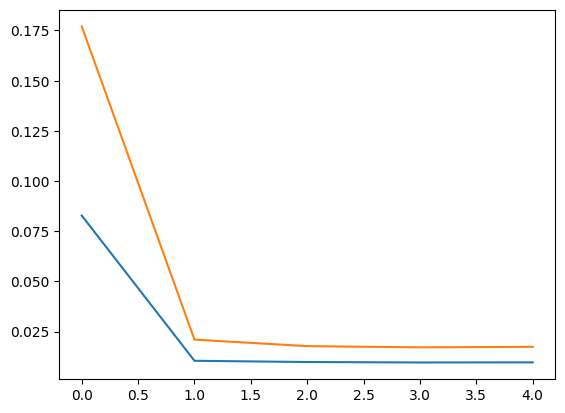

In [ ]:
model = model_products()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = t_data.DataLoader(t_data.TensorDataset(x_train, y_train), shuffle=True, batch_size=8)

n_epochs = 500
loss_train, loss_test = [], []
for epoch in range(n_epochs):
    model.train()
    for x_batch, y_batch in loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validacion
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        loss_train.append(train_rmse)
        y_pred = model(x_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        loss_test.append(test_rmse)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.show()

In [ ]:
# torch.save(model, 'model_whey.pt')
model = torch.load('model_whey.pt')

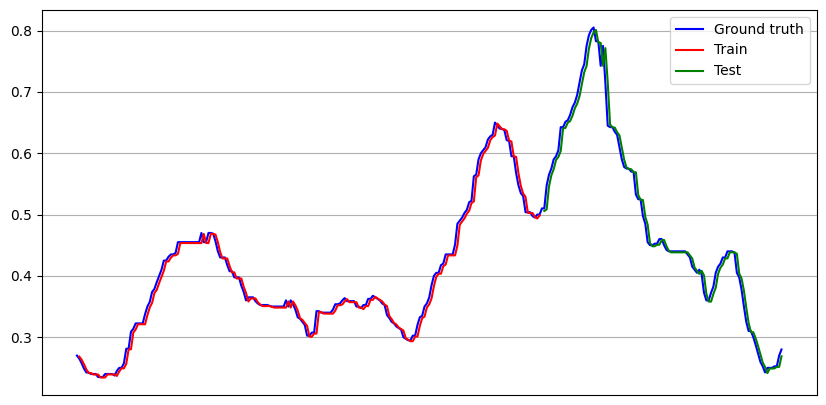

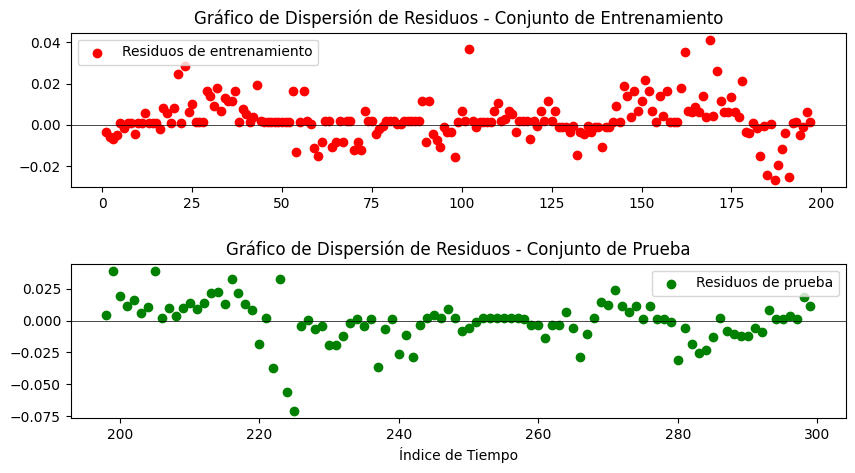

La suma total de los residuos es: 0.5186224591732019, -0.07014122903347053


In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(data[" WHEY CENTRAL"]) * np.nan
    y_pred_train = model(x_train)
    y_pred_train = y_pred_train[:, -1]
    train_plot[lookback:train_size] = y_pred_train

    # shift test predictions for plotting
    test_plot = np.ones_like(data[" WHEY CENTRAL"]) * np.nan
    y_pred_test = model(x_test)
    test_plot[train_size+lookback:] = y_pred_test[:, -1]

# plot
fig = plt.figure(figsize=(10,5))
plt.plot(data[" WHEY CENTRAL"].values, c='b', label='Ground truth')
plt.plot(train_plot, c='r', label='Train')
plt.plot(test_plot, c='g', label='Test')
plt.legend()
plt.xticks([])
plt.grid()
plt.show()

# Calcular residuos
train_residuals = data[" WHEY CENTRAL"][:train_size] - train_plot[:train_size]
test_residuals = data[" WHEY CENTRAL"][train_size+lookback:] - test_plot[train_size+lookback:]

# Visualizar residuos
fig, ax = plt.subplots(2, 1, figsize=(10,5))

# Gráfico de dispersión de residuos para conjunto de entrenamiento
ax[0].scatter(range(train_size), train_residuals, color='r', label='Residuos de entrenamiento')
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].set_title('Gráfico de Dispersión de Residuos - Conjunto de Entrenamiento')
ax[0].legend()

# Gráfico de dispersión de residuos para conjunto de prueba
ax[1].scatter(range(train_size, len(data) - 1), test_residuals, color='g', label='Residuos de prueba')
ax[1].axhline(0, color='black', linewidth=0.5)
ax[1].set_title('Gráfico de Dispersión de Residuos - Conjunto de Prueba')
ax[1].set_xlabel('Índice de Tiempo')
ax[1].legend()

# Ajustar el espacio vertical entre los subgráficos
plt.subplots_adjust(hspace=0.5)
plt.show()

# Calcular y mostrar la suma de los residuos
print(f"La suma total de los residuos es: {np.sum(train_residuals)}, {np.sum(test_residuals)}")

### Predicciones

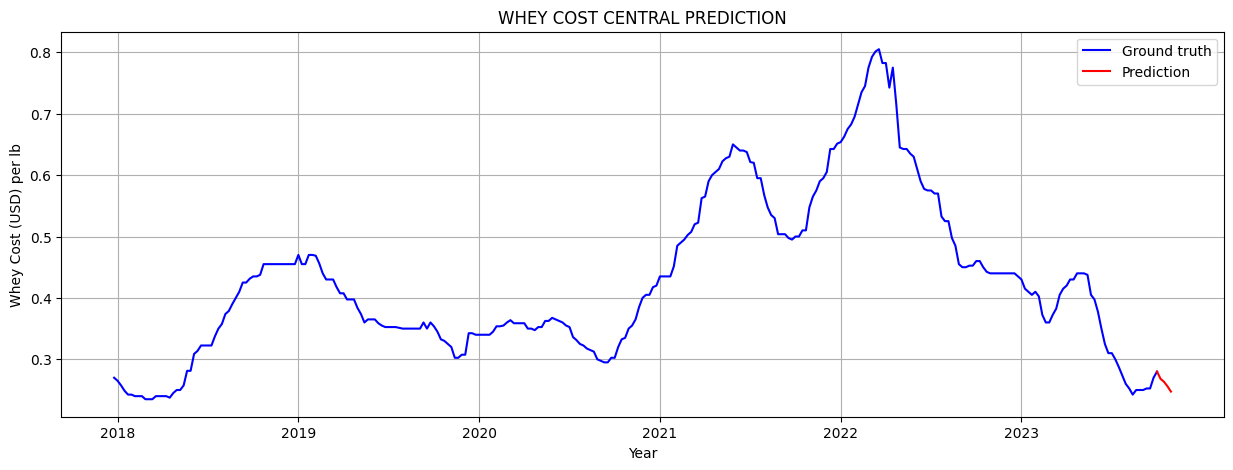

   Whey Cost
0   0.280000
1   0.268320
2   0.263403
3   0.256034
4   0.247448


In [ ]:
# Make 4 weeks prediction
model.eval()
with torch.no_grad():
    # Take all data
    x = data[" WHEY CENTRAL"].values.astype('float32')
    # Transform to tensor
    x = torch.tensor(x).unsqueeze(0).unsqueeze(2)
    # Initialize predictions
    predictions = []
    # Loop for 4 weeks
    for i in range(4):
        # Make prediction for next week
        y_pred = model(x)
        # Update x, remove first value and append prediction
        x = torch.cat([x[:, 1:], y_pred], dim=1)
        # Append prediction to predictions
        predictions.append(y_pred[0, 0].item())
        
# Add last value of data to predictions
predictions = np.append(data[" WHEY CENTRAL"].values[-1], predictions)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(data[" WHEY CENTRAL"].values, c='b', label='Ground truth')
plt.plot(np.arange(len(data[" WHEY CENTRAL"].values) - 1, len(data[" WHEY CENTRAL"].values)+4), predictions, c='r', label='Prediction')
plt.legend()
plt.xticks([1 + i*52 for i in range(6)], [2018 + i for i in range(6)])
plt.title("WHEY COST CENTRAL PREDICTION")
plt.grid(axis='both')
plt.xlabel("Year")
plt.ylabel("Whey Cost (USD) per lb")
plt.show()

print(pd.DataFrame(predictions, columns=['Whey Cost']))

## Modelo Lactosa

In [ ]:
lookback = 1
x_train2, y_train2 = create_dataset(np.array(train['Lactose'].values.astype('float32')), lookback)
x_test2, y_test2 = create_dataset(np.array(test['Lactose'].values.astype('float32')), lookback)
print(x_train2.shape, y_train2.shape)
print(x_test2.shape,  y_test2.shape)

torch.Size([197, 1]) torch.Size([197, 1])
torch.Size([102, 1]) torch.Size([102, 1])


Epoch 0: train RMSE 0.1266, test RMSE 0.1298
Epoch 100: train RMSE 0.0073, test RMSE 0.0081
Epoch 200: train RMSE 0.0069, test RMSE 0.0098
Epoch 300: train RMSE 0.0065, test RMSE 0.0083
Epoch 400: train RMSE 0.0065, test RMSE 0.0085


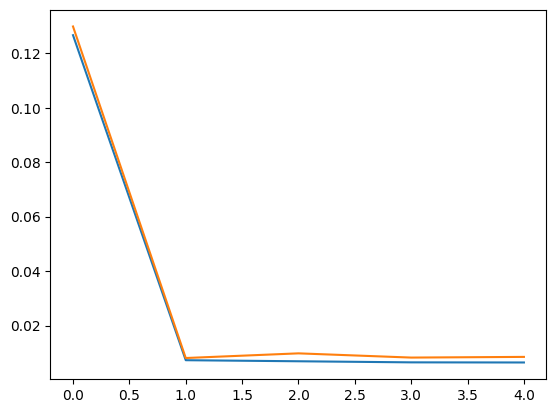

In [ ]:
model_2 = model_products()
optimizer2 = optim.Adam(model_2.parameters())
loss_fn2 = nn.MSELoss()
loader2 = t_data.DataLoader(t_data.TensorDataset(x_train2, y_train2), shuffle=True, batch_size=8)

n_epochs = 500
loss_train, loss_test = [], []
for epoch in range(n_epochs):
    model_2.train()
    for x_batch, y_batch in loader2:
        y_pred = model_2(x_batch)
        loss2 = loss_fn2(y_pred, y_batch)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
    # Validacion
    if epoch % 100 != 0:
        continue
    model_2.eval()
    with torch.no_grad():
        y_pred = model_2(x_train2)
        train_rmse = np.sqrt(loss_fn2(y_pred, y_train2))
        loss_train.append(train_rmse)
        y_pred = model_2(x_test2)
        test_rmse = np.sqrt(loss_fn2(y_pred, y_test2))
        loss_test.append(test_rmse)
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.show()

In [ ]:
torch.save(model_2, 'model_lactose.pt')
model_2 = torch.load('model_lactose.pt')

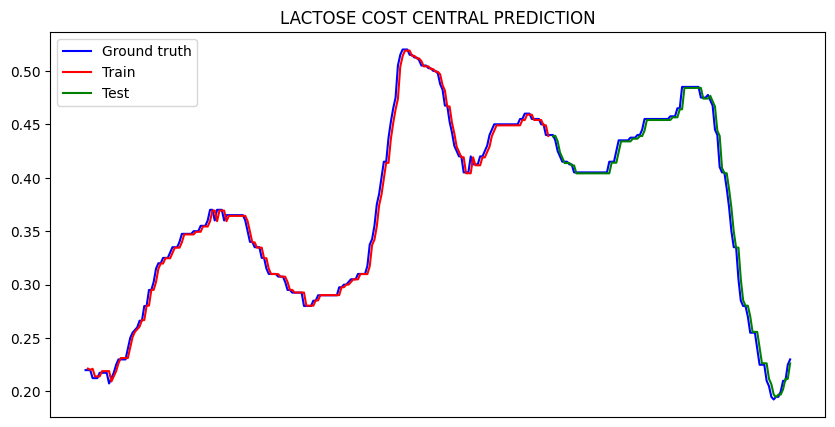

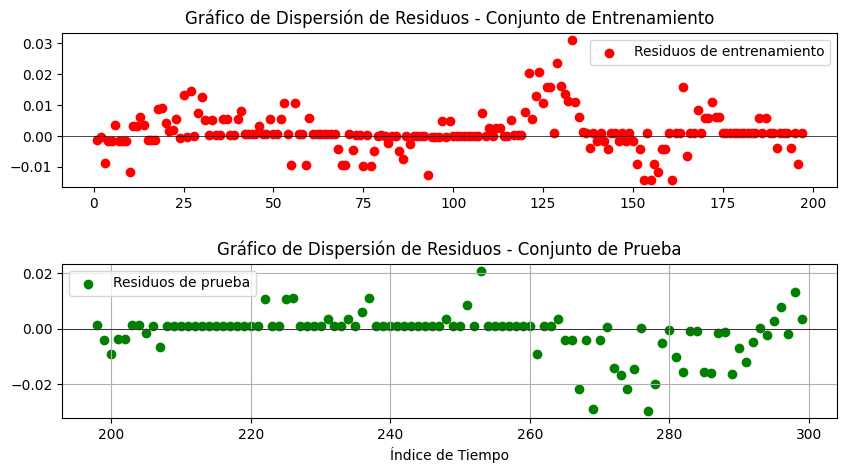

La suma total de los residuos es: 0.11767030775547041


In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(data["Lactose"]) * np.nan
    y_pred = model_2(x_train2)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = model_2(x_train2)[:, -1].cpu()
    # shift test predictions for plotting
    test_plot = np.ones_like(data["Lactose"]) * np.nan
    test_plot[train_size+lookback:] = model_2(x_test2)[:, -1].cpu()
# plot
fig = plt.figure(figsize=(10,5))
plt.plot(data["Lactose"].values, c='b', label='Ground truth')
plt.plot(train_plot, c='r', label='Train')
plt.plot(test_plot, c='g', label='Test')
plt.legend()
plt.xticks([])
plt.title("LACTOSE COST CENTRAL PREDICTION")
plt.show()


# Calcular residuos
train_residuals = data["Lactose"][:train_size] - train_plot[:train_size]
test_residuals = data["Lactose"][train_size+lookback:] - test_plot[train_size+lookback:]

# Visualizar residuos
fig, ax = plt.subplots(2, 1, figsize=(10,5))

# Gráfico de dispersión de residuos para conjunto de entrenamiento
ax[0].scatter(range(train_size), train_residuals, color='r', label='Residuos de entrenamiento')
ax[0].axhline(0, color='black', linewidth=0.5)
ax[0].set_title('Gráfico de Dispersión de Residuos - Conjunto de Entrenamiento')
ax[0].legend()

# Gráfico de dispersión de residuos para conjunto de prueba
ax[1].scatter(range(train_size, len(data) - 1), test_residuals, color='g', label='Residuos de prueba')
ax[1].axhline(0, color='black', linewidth=0.5)
ax[1].set_title('Gráfico de Dispersión de Residuos - Conjunto de Prueba')
ax[1].set_xlabel('Índice de Tiempo')
ax[1].legend()

# Ajustar el espacio vertical entre los subgráficos
plt.subplots_adjust(hspace=0.5)
plt.grid()
plt.show()

# Calcular y mostrar la suma de los residuos
print(f"La suma total de los residuos es: {np.sum(train_residuals) + np.sum(test_residuals)}")

### Predicciones

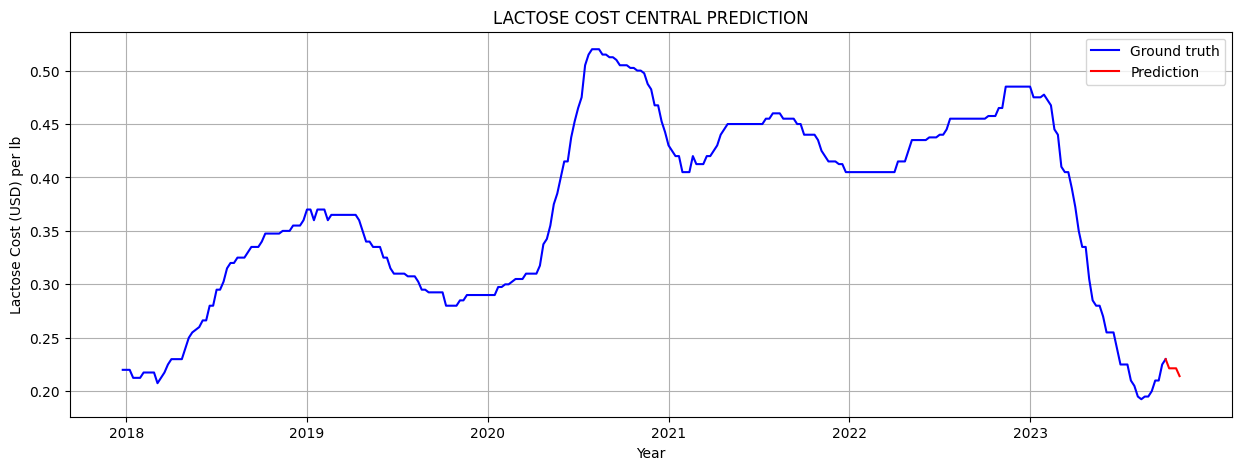

    Lactose
0  0.230000
1  0.221422
2  0.221422
3  0.221422
4  0.214141


In [ ]:
# Make 4 weeks prediction
model_2.eval()
with torch.no_grad():
    # Take all data
    x = data["Lactose"].values.astype('float32')
    # Transform to tensor
    x = torch.tensor(x).unsqueeze(0).unsqueeze(2)
    # Initialize predictions
    predictions = []
    
    # Loop for 4 weeks
    for i in range(4):
        # Make prediction for next week
        y_pred = model_2(x)
        # Update x, remove first value and append prediction
        x = torch.cat([x[:, 1:], y_pred], dim=1)
        # Append prediction to predictions
        predictions.append(y_pred[0, 0].item())
        
# Add last value of data to predictions
predictions = np.append(data["Lactose"].values[-1], predictions)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(data["Lactose"].values, c='b', label='Ground truth')
plt.plot(np.arange(len(data["Lactose"].values) - 1, len(data["Lactose"].values)+4), predictions, c='r', label='Prediction')
plt.legend()
plt.xticks([1 + i*52 for i in range(6)], [2018 + i for i in range(6)])
plt.title("LACTOSE COST CENTRAL PREDICTION")
plt.grid(axis='both')
plt.xlabel("Year")
plt.ylabel("Lactose Cost (USD) per lb")
plt.show()

print(pd.DataFrame(predictions, columns=['Lactose']))

## Precio dinámico

### Datos sintéticos

Generación de datos sintéticos para cada producto. Los datos tienen 2mil toneladas como mínimo y 10mil como máximo, por producto. La media es de 5mil, aproximadamente; desviación estándar de ±2mil toneladas para lactosa y ±1.5 mil toneladas para suero (whey).

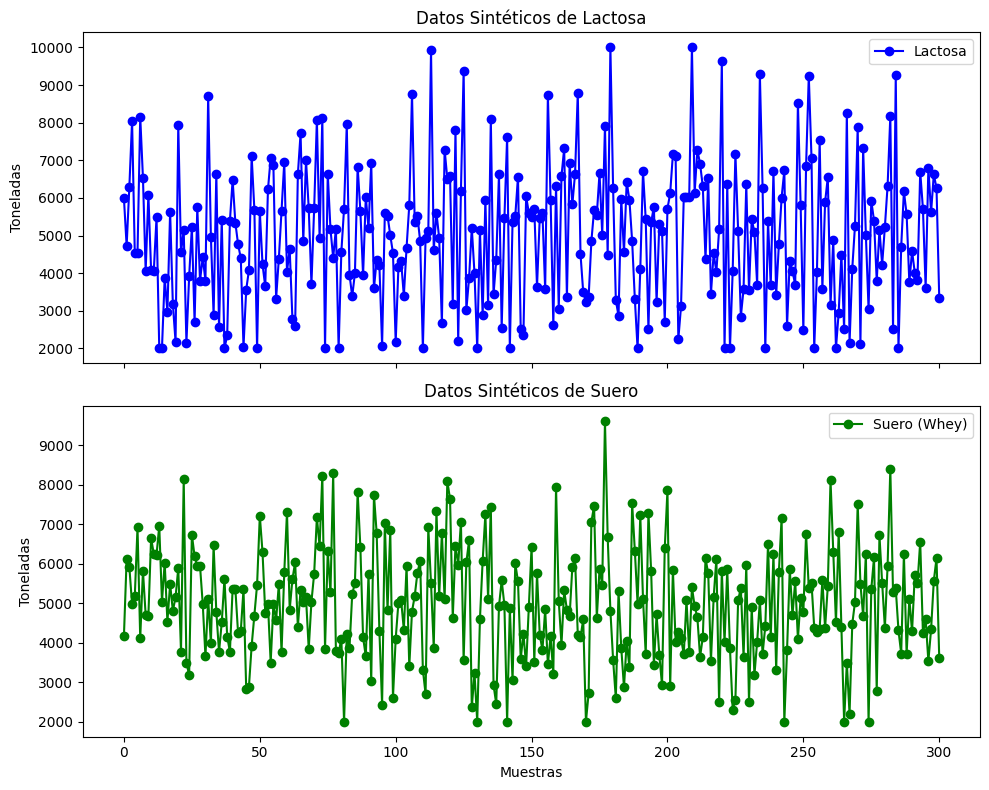

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cantidad de datos generados
size = data['Lactose'].size

# Semilla para reproducibilidad
np.random.seed(42)

# Definir características para lactosa
media_lactosa = 5000
desviacion_lactosa = 2000
min_lactosa = 2000
max_lactosa = 10000

# Generar datos sintéticos para lactosa
datos_lactosa = np.random.normal(loc=media_lactosa, scale=desviacion_lactosa, size=size)
datos_lactosa = np.clip(datos_lactosa, min_lactosa, max_lactosa)  # Asegurar que los valores estén en el rango

# Definir características para suero (whey)
media_suero = 5000
desviacion_suero = 1500
min_suero = 2000
max_suero = 10000

# Generar datos sintéticos para suero
datos_suero = np.random.normal(loc=media_suero, scale=desviacion_suero, size=size)
datos_suero = np.clip(datos_suero, min_suero, max_suero)  # Asegurar que los valores estén en el rango

# Crear gráficos de puntos y líneas
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Gráfico para lactosa
ax[0].plot(datos_lactosa, marker='o', linestyle='-', color='blue', label='Lactosa')
ax[0].set_ylabel('Toneladas')
ax[0].legend()
ax[0].set_title('Datos Sintéticos de Lactosa')

# Gráfico para suero
ax[1].plot(datos_suero, marker='o', linestyle='-', color='green', label='Suero (Whey)')
ax[1].set_xlabel('Muestras')
ax[1].set_ylabel('Toneladas')
ax[1].legend()
ax[1].set_title('Datos Sintéticos de Suero')

plt.tight_layout()
plt.show()
df_week = data.index

# unimos ambos datos en un DataFrame
df_inventario = pd.DataFrame({
    'Date' : data['Week'].values, 
    'Lactose': datos_lactosa,
    'Whey': datos_suero
})


df_inventario = df_inventario.reset_index(drop=True)
df_inventario.to_csv('inventario.csv', index=False) 

In [ ]:
data

,Week,WHEY CENTRAL,Lactose
0,2017-12-31,0.27000,0.2200
1,2018-01-07,0.26500,0.2200
2,2018-01-14,0.25750,0.2200
3,2018-01-21,0.24875,0.2125
4,2018-01-28,0.24250,0.2125
...,...,...,...
296,2023-08-11,0.25000,0.2000
297,2023-08-18,0.25250,0.2100
298,2023-08-25,0.25250,0.2100
299,2023-09-01,0.27000,0.2250


In [ ]:
df_inventario

,Date,Lactose,Whey
0,2017-12-31,5993.428306,4159.728440
1,2018-01-07,4723.471398,6120.940408
2,2018-01-14,6295.377076,5915.555398
3,2018-01-21,8046.059713,4968.647609
4,2018-01-28,4531.693251,5175.991075
...,...,...,...
296,2023-08-11,6799.199751,3531.854426
297,2023-08-18,5614.599042,4333.560110
298,2023-08-25,6625.724238,5565.950740
299,2023-09-01,6259.257684,6135.482925


## Compra limitada

La compra de un solo cliente está limitada a menos del 50% del inventario total. Hay dos tipos de clientes, un cliente $A$ y uno $B$. El cliente $B$ está limitado a un número limitado de toneladas en espera del cliente premiun. 

En este caso el cliente $A$ compra de 50-100 toneladas por mes y el $B$ comprará 100 toneladas.

301 301


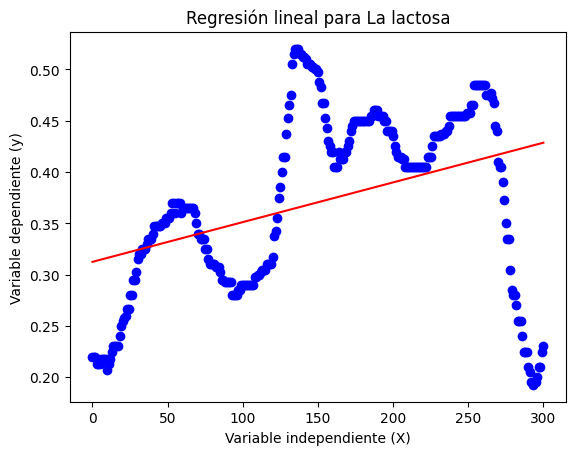

a = 0.3124707102153968, b = 0.00038707234164264817


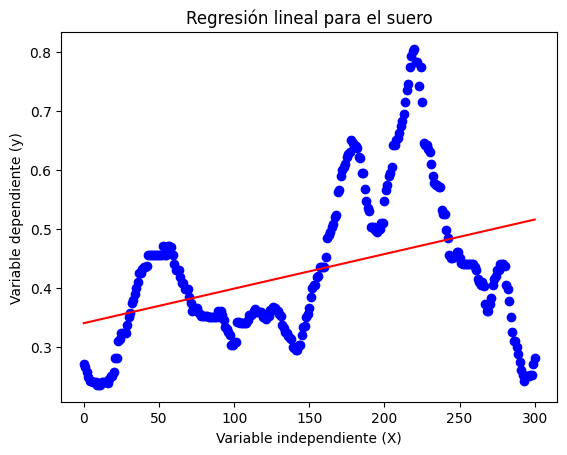

a = 0.3397832280917912, b = 0.0005859689555785351


In [ ]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()

X = np.arange(0, data['Lactose'].size).reshape(-1,1)

# Determinamos los coeficientes para la lactosa
y = data['Lactose'].values
print(len(X), len(y))
modelo.fit(X, y)
predicciones = modelo.predict(X)

b_lactosa = modelo.coef_[0] # la peniente 
a_lactosa = modelo.intercept_ # Ordenada al origen

plt.scatter(X, y, color='blue')  
plt.plot(X, predicciones, color='red')  
plt.xlabel('Variable independiente (X)')
plt.ylabel('Variable dependiente (y)')
plt.title('Regresión lineal para La lactosa')
plt.show()
print(rf"a = {a_lactosa}, b = {b_lactosa}")

# Determinamos los coeficientes para el suero 
y = data[' WHEY CENTRAL'].values
modelo.fit(X, y)
predicciones = modelo.predict(X)

b_suero = modelo.coef_[0] # la peniente 
a_suero = modelo.intercept_ # Ordenada al 

plt.scatter(X, y, color='blue')  
plt.plot(X, predicciones, color='red')  
plt.xlabel('Variable independiente (X)')
plt.ylabel('Variable dependiente (y)')
plt.title('Regresión lineal para el suero')
plt.show()
print(rf"a = {a_suero}, b = {b_suero}")

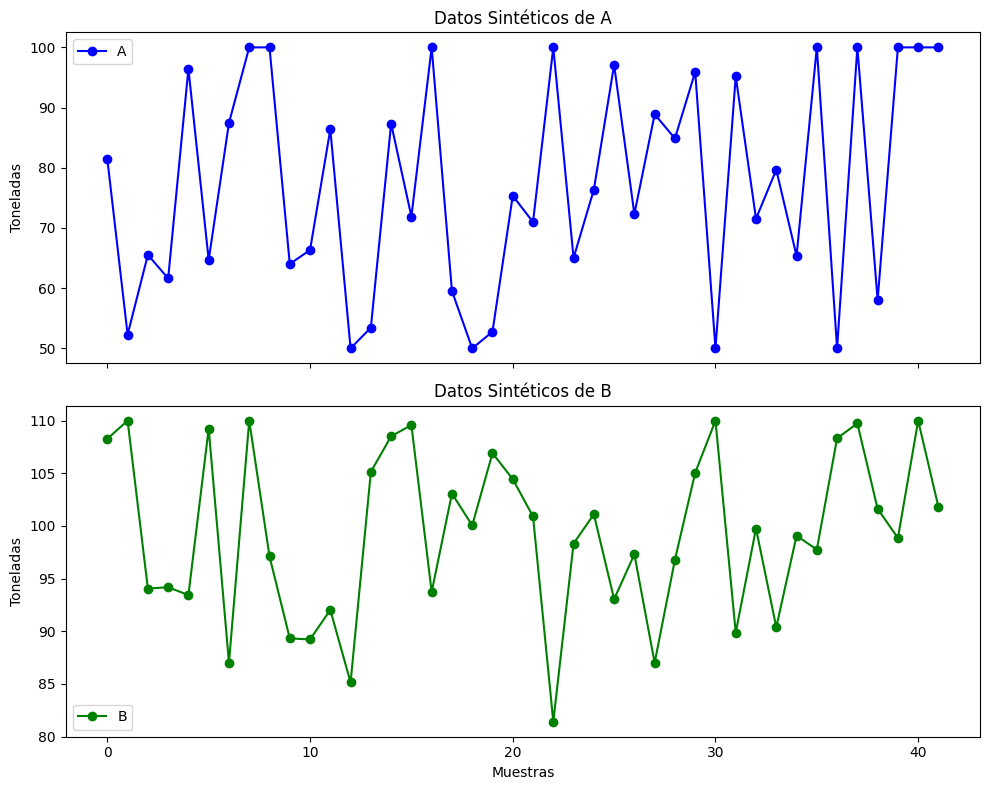

In [ ]:
# Cantidad de datos generados
size = df.size

# Semilla para reproducibilidad
np.random.seed(43)

# Definir características para A
media_A = 75
desviacion_A = 25
min_A = 50
max_A = 100

# Generar datos sintéticos para A
datos_A = np.random.normal(loc=media_A, scale=desviacion_A, size=size)
datos_A = np.clip(datos_A, min_A, max_A)  # Asegurar que los valores estén en el rango

# Definir características para B
media_B = 100
desviacion_B = 10
min_B = 80
max_B = 110

# Generar datos sintéticos para B
datos_B = np.random.normal(loc=media_B, scale=desviacion_B, size=size)
datos_B = np.clip(datos_B, min_B, max_B)  # Asegurar que los valores estén en el rango

# Crear gráficos de puntos y líneas
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Gráfico para A
ax[0].plot(datos_A, marker='o', linestyle='-', color='blue', label='A')
ax[0].set_ylabel('Toneladas')
ax[0].legend()
ax[0].set_title('Datos Sintéticos de A')

# Gráfico para B
ax[1].plot(datos_B, marker='o', linestyle='-', color='green', label='B')
ax[1].set_xlabel('Muestras')
ax[1].set_ylabel('Toneladas')
ax[1].legend()
ax[1].set_title('Datos Sintéticos de B')

plt.tight_layout()
plt.show()

# unimos ambos datos en un DataFrame
df_demandas = pd.DataFrame({
    'A': datos_A,
    'B': datos_B
})
df_demandas = df_demandas.reset_index(drop=True)


In [ ]:
def Lactose_predictions(num_prediction):
    # Make 4 weeks prediction
    model_2.eval()
    with torch.no_grad():
        # Take all data
        x = data["Lactose"].values.astype('float32')
        # Transform to tensor
        x = torch.tensor(x).unsqueeze(0).unsqueeze(2)
        # Initialize predictions
        predictions = []
        # Loop for 4 weeks
        for i in range(num_prediction):
            # Make prediction for next week
            y_pred = model_2(x)
            # Update x, remove first value and append prediction
            x = torch.cat([x[:, 1:], y_pred], dim=1)
            # Append prediction to predictions
            predictions.append(y_pred[0, 0].item())
        
    return predictions

def Whey_predictions(num_prediction): 
    model.eval()
    with torch.no_grad():
        # Take all data
        x = data[" WHEY CENTRAL"].values.astype('float32')
        # Transform to tensor
        x = torch.tensor(x).unsqueeze(0).unsqueeze(2)
        # Initialize predictions
        predictions = []
        # Loop for 4 weeks
        for i in range(num_prediction):
            # Make prediction for next week
            y_pred = model(x)
            # Update x, remove first value and append prediction
            x = torch.cat([x[:, 1:], y_pred], dim=1)
            # Append prediction to predictions
            predictions.append(y_pred[0, 0].item())
    return predictions


In [ ]:
def Optimal_price(a,b):
    return a/(2*b)

print(Optimal_price(a_lactosa, b_lactosa))
print(Optimal_price(a_suero, b_suero))

403.63347699985644
289.9327898321154


Lactosa, precio para cliente A= 510.719, para cliente B=221.422
Suero,   precio para cliente A= 348.948, para cliente B=268.32
Lactosa, precio para cliente A= 538.45, para cliente B=221.422
Suero,   precio para cliente A= 367.834, para cliente B=263.403
Lactosa, precio para cliente A= 560.72, para cliente B=221.422
Suero,   precio para cliente A= 389.182, para cliente B=256.034
Lactosa, precio para cliente A= 588.838, para cliente B=214.141
Suero,   precio para cliente A= 404.332, para cliente B=247.448


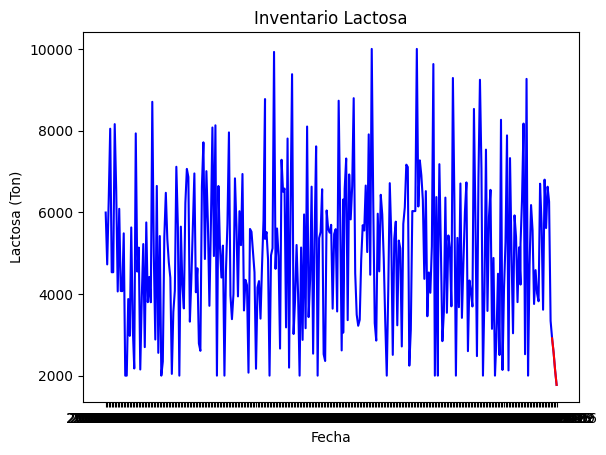

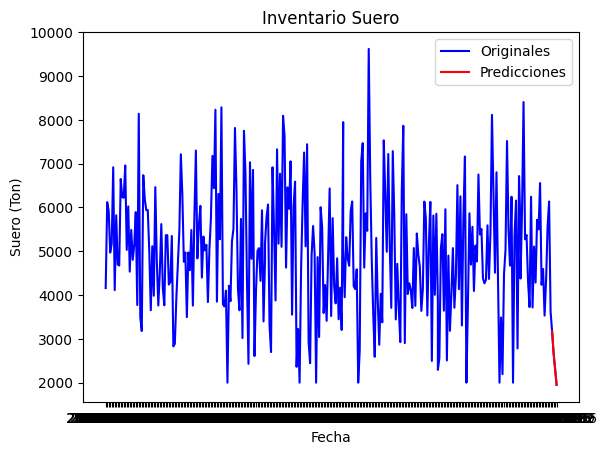

In [ ]:

iteraciones = 4
p_pred_suero   = Whey_predictions(iteraciones)
p_pred_lactosa = Lactose_predictions(iteraciones)

b = 0.02

for i in range(iteraciones): 
    precio_lactosa = p_pred_lactosa[i]*1000
    precio_suero   = p_pred_suero[i]*1000
    # Demanda para 
    p_optimal_lactosa = Optimal_price(a_lactosa+(5000 - df_inventario['Lactose'].iloc[-1])/20000, b_lactosa)
    p_optimal_suero   = Optimal_price(a_suero+(5000 - df_inventario['Whey'].iloc[-1])/20000, b_suero)
    # print(rf" -pred {precio_lactosa},{precio_lactosa}")
    # print(rf" -pred {p_optimal_lactosa},{p_optimal_suero}")
    print(rf"Lactosa, precio para cliente A= {round(max(precio_lactosa, p_optimal_lactosa),3)}, para cliente B={round(min(precio_lactosa, p_optimal_lactosa), 3)}")
    print(rf"Suero,   precio para cliente A= {round(max(precio_suero, p_optimal_suero),3)}, para cliente B={round(min(precio_suero, p_optimal_suero), 3)}")

    DA_suero = np.random.randint(50, 101) - b*p_optimal_suero # Demanda en A
    DB_suero  = np.random.randint(250, 501) - b*precio_suero # Demanda en B

    # print(DA_suero, DB_suero )
    if DA_suero >= 0.5*(df_inventario['Whey'].iloc[-1]): 
        DA_suero = 0.5*(df_inventario['Whey'].iloc[-1])
    elif DB_suero >= 0.5*(df_inventario['Whey'].iloc[-1]): 
        DB_suero = 0.5*(df_inventario['Whey'].iloc[-1])

    DA_lactosa = np.random.randint(50, 101) - b*p_optimal_lactosa # Demanda en A
    DB_lactosa  = np.random.randint(250, 501) - b*precio_lactosa # Demanda en B
    # print(DA_lactosa, DB_lactosa)

    if DA_lactosa >= 0.5*(df_inventario['Lactose'].iloc[-1]):
        DA_lactosa = 0.5*(df_inventario['Lactose'].iloc[-1])
    elif DA_lactosa >= 0.5*(df_inventario['Lactose'].iloc[-1]):
        DB_lactosa = 0.5*(df_inventario['Lactose'].iloc[-1])
    

    nueva_fecha = datetime.strptime(df_inventario['Date'].iloc[-1], '%Y-%m-%d') + timedelta(days=7)
    nueva_fecha_str = nueva_fecha.strftime('%Y-%m-%d')

    new_inventario = {'Lactose': df_inventario['Lactose'].iloc[-1] - DA_lactosa - DB_lactosa, 
                  'Whey': df_inventario['Whey'].iloc[-1] - DA_suero - DB_suero,
                  'Date': nueva_fecha_str}

    df_inventario = pd.merge(df_inventario, pd.DataFrame([new_inventario]), how='outer')

plt.plot(df_inventario['Date'], df_inventario['Lactose'], 
        color = 'blue', label = 'Originales')
plt.plot(df_inventario['Date'][-iteraciones:], df_inventario['Lactose'][-iteraciones:], 
        color = 'red', label = 'Predicciones')
plt.title("Inventario Lactosa")
plt.xlabel("Fecha")
plt.ylabel("Lactosa (Ton)")
plt.show()

plt.plot(df_inventario['Date'], df_inventario['Whey'], color = 'blue', label = 'Originales')
plt.plot(df_inventario['Date'][-iteraciones:], df_inventario['Whey'][-iteraciones:], 
        color = 'red', label = 'Predicciones')
plt.title("Inventario Suero")
plt.xlabel("Fecha")
plt.ylabel("Suero (Ton)")
plt.legend()
plt.show()

In [ ]:
p_pred_suero

In [ ]:
p_pred_suero

In [ ]:
df_inventario

,Date,Lactose,Whey
0,2017-12-31,5993.428306,4159.728440
1,2018-01-07,4723.471398,6120.940408
2,2018-01-14,6295.377076,5915.555398
3,2018-01-21,8046.059713,4968.647609
4,2018-01-28,4531.693251,5175.991075
...,...,...,...
300,2023-09-08,3342.009978,3616.752014
301,2023-09-15,2400.511092,2698.917066
302,2023-09-22,1499.012207,1815.983783
303,2023-09-29,676.513321,863.903128


In [ ]:
df_inventario

,Date,Lactose,Whey
0,2017-12-31,5993.428306,4159.728440
1,2018-01-07,4723.471398,6120.940408
2,2018-01-14,6295.377076,5915.555398
3,2018-01-21,8046.059713,4968.647609
4,2018-01-28,4531.693251,5175.991075
...,...,...,...
305,2023-10-13,2492.224320,2763.275845
306,2023-10-20,1557.725434,1906.440898
307,2023-10-27,697.226548,1107.507615
308,2023-11-03,-127.272337,215.426959


## Drift en el modelo

Evidently es una biblioteca Python de código abierto para científicos de datos e ingenieros de ML.
Ayuda a evaluar, probar y supervisar datos y modelos de ML desde la validación hasta la producción. Funciona con datos tabulares, de texto e incrustaciones.

In [ ]:
from evidently.report import Report
from evidently.metrics import DataDriftTable
from evidently.metrics import DatasetDriftMetric

In [ ]:
data_drift = pd.read_csv('data_pricing.csv')


reference_data = data_drift[data_drift['Week'] < '2019-12-27']

comparison_data = data_drift[data_drift['Week'] >= '2019-12-27']

In [ ]:
data_drift_dataset_report = Report(metrics=[

    DatasetDriftMetric(),

    DataDriftTable(),    

])

data_drift_dataset_report.run(reference_data=reference_data, current_data= comparison_data)

data_drift_dataset_report

/opt/conda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning:

divide by zero encountered in divide

/opt/conda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning:

divide by zero encountered in divide



Visualizar el dashboard del Drift de los datos en colab: https://colab.research.google.com/drive/13FZIAqnoj82r7PVgfz40XXvgMRLWPzAW?usp=sharing

Descargar el archivo "data_pricing.csv"  que se encuentra en FIles.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=79363bdc-7315-4f7d-826e-e957ce5b92c5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>